<a href="https://colab.research.google.com/github/shivi13102/Healthcare-Fraud-Provider-Detection-Analysis/blob/main/dataTransform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the cleaned data
train_beneficiary = pd.read_excel('/content/drive/My Drive/FDS PROJECT/Cleaned_Data/train_bene_cleaned_data.xlsx')

In [ ]:
display(train_beneficiary)

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,Country,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,Alive,M,1,N,39,230,12,12,...,1,1,1,0,1,1,36000,3204,60,70
1,BENE11005,1935-09-01,Alive,M,1,N,24,680,12,12,...,0,1,0,0,0,0,0,0,1790,1200
2,BENE11009,1929-06-01,Alive,M,1,Y,44,230,12,12,...,0,1,0,0,0,0,0,0,100,0
3,BENE11010,1936-07-01,Alive,F,1,N,41,30,12,12,...,0,1,1,1,0,0,0,0,1170,660
4,BENE11021,1927-12-01,Alive,M,3,N,7,20,12,12,...,1,1,1,1,1,0,0,0,520,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26813,BENE159184,1940-09-01,Alive,M,1,N,24,260,12,12,...,0,1,1,0,0,0,0,0,1110,230
26814,BENE159185,1935-06-01,Alive,F,1,N,5,90,12,12,...,0,1,0,0,0,0,0,0,70,200
26815,BENE159186,1930-01-01,Alive,F,1,N,5,370,12,12,...,0,1,0,1,0,0,0,0,1180,540
26816,BENE159192,1937-04-01,Alive,F,1,N,21,30,12,12,...,0,1,1,0,1,0,0,0,420,100


###**1. Age Calculation:**
To calculate the beneficiary’s age at the time of reimbursement, we need to check if the beneficiary is alive (DOD is null). If not, use the date of death to calculate the age; otherwise, use the current date.

In [ ]:
# Convert DOB to datetime
train_beneficiary['DOB'] = pd.to_datetime(train_beneficiary['DOB'])

# Convert DOD to datetime, treating 'Alive' as a missing value (NaT)
train_beneficiary['DOD'] = pd.to_datetime(train_beneficiary['DOD'], errors='coerce')

# Set 'DOD' as NaT (Not a Time) where it's 'Alive'
train_beneficiary.loc[train_beneficiary['DOD'].isna() & (train_beneficiary['DOD'] == 'Alive'), 'DOD'] = pd.NaT

# Calculate the current date
current_date = pd.to_datetime('today')

# Create an 'Age' column (based on DOD or current date if DOD is 'Alive' or missing)
train_beneficiary['Age'] = train_beneficiary.apply(
    lambda row: (row['DOD'] - row['DOB']).days // 365
                if pd.notnull(row['DOD'])
                else (current_date - row['DOB']).days // 365, axis=1
)

# View the DataFrame
display(train_beneficiary[['DOB', 'DOD', 'Age']])


<ipython-input-7-9f0a2cfa0853>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_beneficiary['DOD'] = pd.to_datetime(train_beneficiary['DOD'], errors='coerce')


,DOB,DOD,Age
0,1943-01-01,NaT,81
1,1935-09-01,NaT,89
2,1929-06-01,NaT,95
3,1936-07-01,NaT,88
4,1927-12-01,NaT,96
...,...,...,...
26813,1940-09-01,NaT,84
26814,1935-06-01,NaT,89
26815,1930-01-01,NaT,94
26816,1937-04-01,NaT,87


###**2. Chronic Condition Counts:**
This will calculate the number of chronic conditions per BeneID and store it in a new column *ChronicConditionCount*.

In [ ]:
# List of chronic condition columns
chronic_columns = [
    'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
    'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
    'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
    'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke'
]

# Create a 'ChronicConditionCount' column by summing the chronic condition columns row-wise
train_beneficiary['ChronicConditionCount'] = train_beneficiary[chronic_columns].sum(axis=1)

# Now if you want to see the total per BeneID (optional aggregation step)
# Aggregating the ChronicConditionCount per BeneID
chronic_condition_per_beneid = train_beneficiary.groupby('BeneID')['ChronicConditionCount'].sum().reset_index()

# View the updated DataFrame
display(train_beneficiary[['BeneID', 'ChronicConditionCount']])

,BeneID,ChronicConditionCount
0,BENE11001,7
1,BENE11005,2
2,BENE11009,2
3,BENE11010,6
4,BENE11021,7
...,...,...
26813,BENE159184,3
26814,BENE159185,1
26815,BENE159186,2
26816,BENE159192,3


###**3. Filtering the most common Countries**

In [ ]:
# Find the most common numbers in the "Country" column
common_numbers = train_beneficiary['Country'].value_counts()

# Display the most common numbers
display(common_numbers)

,count
Country,
200,3943
10,3587
20,3176
60,3003
90,2833
...,...
742,1
117,1
834,1


###-> High medical fraud rating countries

In [ ]:
# List of numbers to check
numbers_to_check = [234, 91, 27, 7, 86, 55, 52, 63, 380, 20, 57, 54, 51, 84, 66, 62, 60, 90, 98, 92]

# Filter the DataFrame for rows where 'Country' is in the list of numbers
filtered_df = train_beneficiary[train_beneficiary['Country'].isin(numbers_to_check)]

# Count the occurrences of each number
occurrence_counts = filtered_df['Country'].value_counts()

# Display the number of times each number occurred
print(occurrence_counts)


Country
20     3176
60     3003
90     2833
380     870
55       11
84        2
Name: count, dtype: int64


In [ ]:
# List of country codes to check
country_codes_to_check = [20, 60, 90, 380, 55, 84]

# Filter the DataFrame for rows where 'Country' is in the list of country codes
filtered_df = train_beneficiary[train_beneficiary['Country'].isin(country_codes_to_check)]

# Convert state codes to strings and group by country code
grouped_state_codes = (filtered_df
    .assign(State=filtered_df['State'].astype(str))  # Convert state codes to strings
    .groupby('Country')['State']
    .apply(lambda x: ', '.join(x.unique()))  # Join unique state codes into a comma-separated string
    .reset_index()
    .rename(columns={'State': 'StateCodes'})  # Rename column for clarity
)

# Display the grouped state codes
print(grouped_state_codes)



   Country                                         StateCodes
0       20  7, 33, 12, 2, 21, 32, 50, 6, 5, 23, 52, 43, 22...
1       55                                                  3
2       60  18, 3, 27, 22, 36, 34, 11, 42, 44, 21, 33, 6, ...
3       84                                                 30
4       90  3, 5, 11, 45, 42, 20, 22, 10, 13, 34, 30, 26, ...
5      380  26, 42, 5, 19, 1, 23, 49, 39, 35, 25, 50, 6, 3...


In [ ]:
# List of state codes to check
state_codes_to_check = [2, 68, 97, 82, 57, 64, 95, 50, 48, 66, 65, 62, 69, 15, 554]

# Filter the DataFrame for rows where 'Country' is 20
filtered_df_country_20 = train_beneficiary[train_beneficiary['Country'] == 20]

# Check if any of the state codes are present in the 'State' column for country code 20
present_states = filtered_df_country_20[filtered_df_country_20['State'].isin(state_codes_to_check)]

# Display the state codes that are present
print("Present state codes:")
print(present_states[['State']].drop_duplicates())


Present state codes:
     State
27       2
55      50
164     15


###**4. Normalization**

*   After normalization, features like IPAnnualReimbursementAmt, OPAnnualReimbursementAmt, IPAnnualDeductibleAmt, and OPAnnualDeductibleAmt will be scaled to the same range.
*   This ensures that these financial metrics don't dominate over other binary or categorical features (e.g., chronic conditions or gender). We'll avoid biases in model training, leading to more balanced insights from the dataset.
*   After training your fraud detection model on normalized data, you may observe improvements in metrics like accuracy, precision, recall, and F1 score.





In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Select the columns to normalize
cols_to_normalize = ['IPAnnualReimbursementAmt', 'OPAnnualReimbursementAmt',
                     'IPAnnualDeductibleAmt', 'OPAnnualDeductibleAmt']

# Initialize the scaler
scaler = MinMaxScaler()

# Normalize the data and replace the original columns
train_beneficiary[cols_to_normalize] = scaler.fit_transform(train_beneficiary[cols_to_normalize])


In [ ]:
display(train_beneficiary)

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,Country,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,ChronicConditionCount
0,BENE11001,1943-01-01,NaT,M,1,N,39,230,12,12,...,1,0,1,1,0.238217,0.091365,0.000939,0.005790,81,7
1,BENE11005,1935-09-01,NaT,M,1,N,24,680,12,12,...,0,0,0,0,0.008917,0.000000,0.021249,0.099256,89,2
2,BENE11009,1929-06-01,NaT,M,1,Y,44,230,12,12,...,0,0,0,0,0.008917,0.000000,0.001409,0.000000,95,2
3,BENE11010,1936-07-01,NaT,F,1,N,41,30,12,12,...,1,1,0,0,0.008917,0.000000,0.013970,0.054591,88,6
4,BENE11021,1927-12-01,NaT,M,3,N,7,20,12,12,...,1,1,1,0,0.008917,0.000000,0.006340,0.012407,96,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26813,BENE159184,1940-09-01,NaT,M,1,N,24,260,12,12,...,1,0,0,0,0.008917,0.000000,0.013266,0.019024,84,3
26814,BENE159185,1935-06-01,NaT,F,1,N,5,90,12,12,...,0,0,0,0,0.008917,0.000000,0.001057,0.016543,89,1
26815,BENE159186,1930-01-01,NaT,F,1,N,5,370,12,12,...,0,1,0,0,0.008917,0.000000,0.014088,0.044665,94,2
26816,BENE159192,1937-04-01,NaT,F,1,N,21,30,12,12,...,1,0,1,0,0.008917,0.000000,0.005166,0.008271,87,3


#**Exploratory Data Analysis (EDA)**

##**A) Descriptive Statistics:**


###1. Summary statistics for numerical columns (e.g., mean, median, min, max of reimbursement amounts).


In [ ]:
# Summary statistics for numerical columns
numeric_cols = ['IPAnnualReimbursementAmt', 'OPAnnualReimbursementAmt',
                'IPAnnualDeductibleAmt', 'OPAnnualDeductibleAmt',
                'NoOfMonths_PartACov', 'NoOfMonths_PartBCov']
summary_stats = train_beneficiary[numeric_cols].describe()
display(summary_stats)


,IPAnnualReimbursementAmt,OPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualDeductibleAmt,NoOfMonths_PartACov,NoOfMonths_PartBCov
count,26818.000000,26818.000000,26818.000000,26818.000000,26818.000000,26818.000000
mean,0.032467,0.015057,0.011575,0.030408,11.904579,11.902379
std,0.061320,0.028153,0.028052,0.052166,1.054626,0.968429
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.008917,0.002113,0.000000,0.003309,12.000000,12.000000
50%,0.008917,0.006692,0.000000,0.013234,12.000000,12.000000
75%,0.028025,0.017492,0.030455,0.036394,12.000000,12.000000
max,1.000000,1.000000,1.000000,1.000000,12.000000,12.000000


1. IPAnnualReimbursementAmt & OPAnnualReimbursementAmt
* Mean: The average reimbursement amounts for both inpatient (IP) and outpatient (OP) are very low (0.032 and 0.015 respectively). This suggests that a large portion of the claims could be relatively small, or that many of the beneficiaries have no claims.
* Min and Max: The minimum reimbursement is 0 for both, which means some beneficiaries had no reimbursements. The maximum reimbursement is 1, which may indicate that the amounts were scaled or normalized to this range.
* Distribution (25%, 50%, 75%): The majority of the beneficiaries (at least 50%) have very low reimbursement amounts (around 0.008917), but there's a steep increase in the third quartile (75th percentile) showing that some beneficiaries receive significantly higher reimbursements.
2. IPAnnualDeductibleAmt & OPAnnualDeductibleAmt:
* Mean & Distribution: Similar to the reimbursement amounts, the deductible amounts are low, with means of 0.011 and 0.030 for inpatient and outpatient, respectively. The distribution suggests that many beneficiaries have low or no deductible amounts, but some may have deductibles close to 1.
* Max of 1: Like the reimbursement amounts, the deductible amounts are capped at 1. This also hints that the dataset may have normalized values.

3. NoOfMonths_PartACov & NoOfMonths_PartBCov
* Mean: Both coverage variables have means around 11.9, indicating that most beneficiaries are covered for nearly the entire year.
* Min: There are some cases where beneficiaries have no coverage (min of 0 months), which could indicate that they either have newly enrolled or have lost coverage.
* Distribution: The 25th, 50th, and 75th percentiles are all 12 months, showing that most beneficiaries have full coverage for both Part A and Part B.

#### Conclusions:
1. Reimbursement and Deductible Amounts: The fact that many values are low suggests either that most claims are small, or that a majority of beneficiaries have few claims.
2. Coverage: Most beneficiaries are covered for the entire year, but a small fraction has gaps in coverage (less than 12 months).

###2. Distribution of chronic conditions and gender across beneficiaries: Counts the number of beneficiaries with specific chronic conditions and breaks down gender distribution.

In [ ]:
# Distribution of gender
gender_dist = train_beneficiary['Gender'].value_counts()
display(gender_dist)

# Count the number of beneficiaries with each chronic condition
chronic_cols = [col for col in train_beneficiary.columns if 'ChronicCond' in col]
chronic_cond_dist = train_beneficiary[chronic_cols].apply(pd.Series.value_counts).loc[1]
display(chronic_cond_dist)


,count
Gender,
F,15341
M,11477


,1
ChronicCond_Alzheimer,8925.0
ChronicCond_Heartfailure,13158.0
ChronicCond_KidneyDisease,8219.0
ChronicCond_Cancer,3154.0
ChronicCond_ObstrPulmonary,6396.0
ChronicCond_Depression,9368.0
ChronicCond_Diabetes,16007.0
ChronicCond_IschemicHeart,18070.0
ChronicCond_Osteoporasis,7213.0
ChronicCond_rheumatoidarthritis,6800.0


1. Gender Distribution: There are more female beneficiaries (15,341) than male beneficiaries (11,477).
2. Prevalence of Chronic Conditions:
* ChronicCond_Diabetes and ChronicCond_IschemicHeart are the most prevalent conditions, affecting 16,007 and 18,070 beneficiaries, respectively.
* ChronicCond_Stroke and ChronicCond_Cancer are the least common, affecting 2,118 and 3,154 beneficiaries, respectively.
* Chronic Condition Count: The average beneficiary has approximately 3.2 chronic conditions, suggesting that comorbidities are common in this population.

##**B) Visualiztion:**


###1. **Histograms:** It will show the distribution of IPAnnualReimbursementAmt, OPAnnualReimbursementAmt, and age.

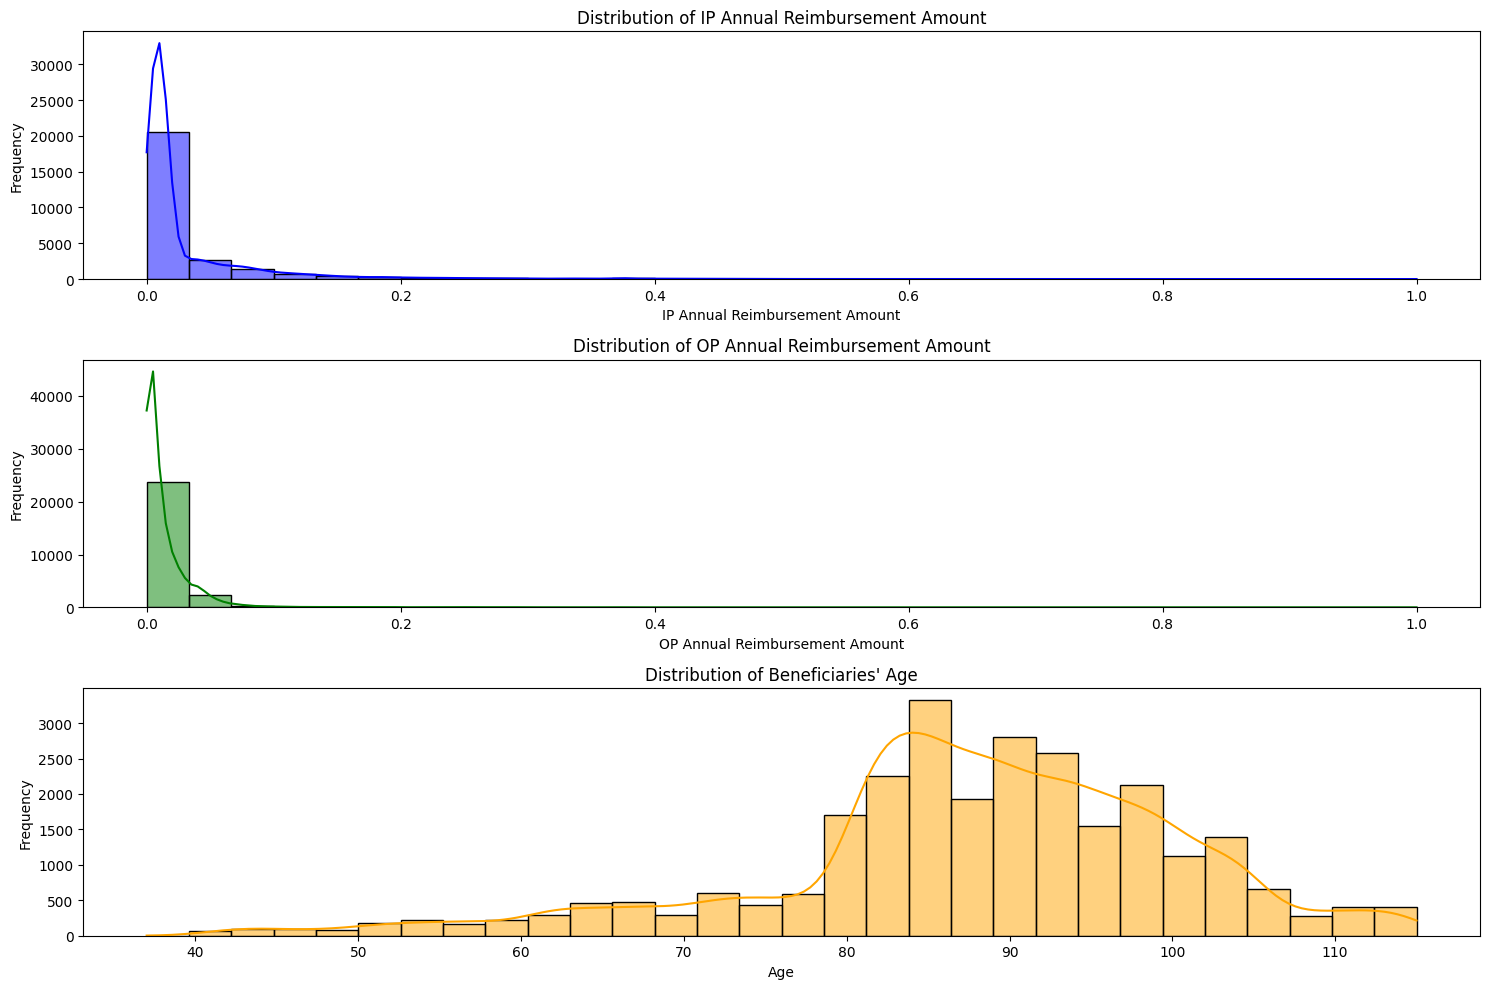

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot size for better readability
plt.figure(figsize=(15, 10))

# Histogram for IPAnnualReimbursementAmt
plt.subplot(3, 1, 1)
sns.histplot(train_beneficiary['IPAnnualReimbursementAmt'], bins=30, kde=True, color='blue')
plt.title('Distribution of IP Annual Reimbursement Amount')
plt.xlabel('IP Annual Reimbursement Amount')
plt.ylabel('Frequency')

# Histogram for OPAnnualReimbursementAmt
plt.subplot(3, 1, 2)
sns.histplot(train_beneficiary['OPAnnualReimbursementAmt'], bins=30, kde=True, color='green')
plt.title('Distribution of OP Annual Reimbursement Amount')
plt.xlabel('OP Annual Reimbursement Amount')
plt.ylabel('Frequency')

# Histogram for Age
plt.subplot(3, 1, 3)
sns.histplot(train_beneficiary['Age'], bins=30, kde=True, color='orange')
plt.title('Distribution of Beneficiaries\' Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

* The distribution of IP Annual Reimbursement Amounts is highly skewed to the right, with most values concentrated near zero, indicating that the majority of beneficiaries have low or no inpatient reimbursement amounts.
* The OP Annual Reimbursement Amount distribution shows a right-skewed distribution with a long tail, indicating a large number of beneficiaries receiving lower amounts.
* The Age distribution shows a peak around 80-90, suggesting a significant portion of beneficiaries are in this age range.

###2. **Box Plots:** Box plots will help identify outliers in the reimbursement and deductible amounts.

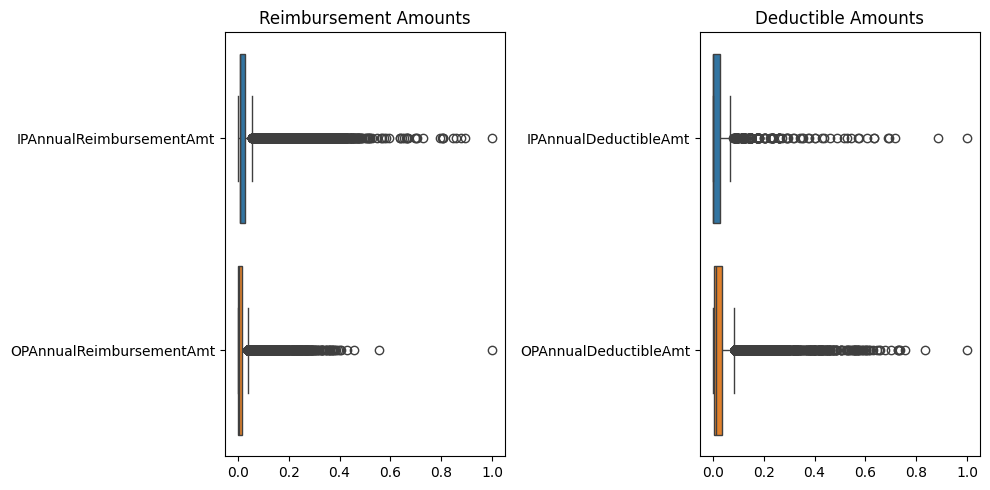

In [ ]:
# Box plot for Reimbursement and Deductible Amounts
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# IPAnnual and OPAnnual Reimbursement Box Plots
sns.boxplot(data=train_beneficiary[['IPAnnualReimbursementAmt', 'OPAnnualReimbursementAmt']], ax=axes[0], orient='h')
axes[0].set_title('Reimbursement Amounts')

# IPAnnual and OPAnnual Deductible Box Plots
sns.boxplot(data=train_beneficiary[['IPAnnualDeductibleAmt', 'OPAnnualDeductibleAmt']], ax=axes[1], orient='h')
axes[1].set_title('Deductible Amounts')

plt.tight_layout()
plt.show()


* The boxplots show that IP Annual Reimbursement Amounts are generally higher than OP Annual Reimbursement Amounts, and IP Annual Deductible Amounts are generally higher than OP Annual Deductible Amounts.
*Both reimbursement and deductible amounts have a few outliers on the higher end.

###3. **Bar Chart for Chronic Conditions:** To visualize the prevalence of different chronic conditions

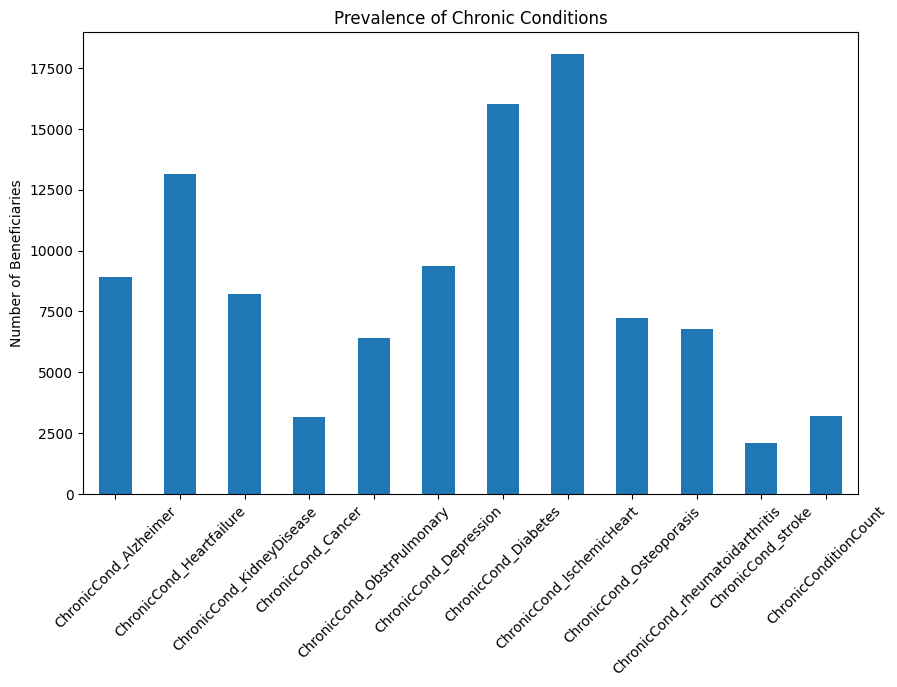

In [ ]:
# Bar chart for chronic conditions
chronic_cond_dist.plot(kind='bar', figsize=(10, 6))
plt.title('Prevalence of Chronic Conditions')
plt.ylabel('Number of Beneficiaries')
plt.xticks(rotation=45)
plt.show()


* The most prevalent conditions are Alzheimer's disease, heart failure, diabetes, and depression.
* The least prevalent conditions are cancer, rheumatoid arthritis, and stroke.

###4. **Correlation Matrix:** The correlation matrix shows relationships between numerical variables, like reimbursement amounts, deductible amounts, and chronic conditions

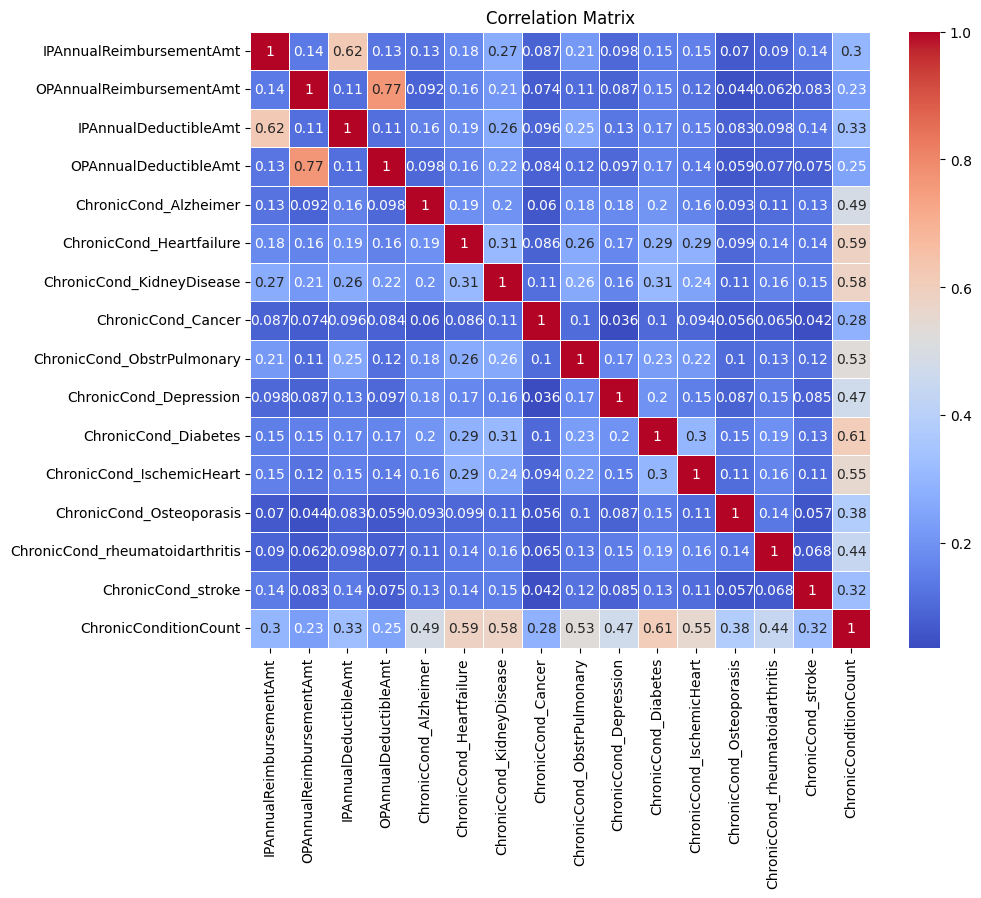

In [ ]:
# Correlation Matrix
corr_matrix = train_beneficiary[['IPAnnualReimbursementAmt', 'OPAnnualReimbursementAmt',
                  'IPAnnualDeductibleAmt', 'OPAnnualDeductibleAmt'] + chronic_cols].corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


Positive Correlations:

* Reimbursement Amounts and Deductible Amounts: IPAnnualReimbursementAmt and IPAnnualDeductibleAmt have a strong positive correlation (0.62), indicating that beneficiaries with higher reimbursement amounts also tend to have higher deductible amounts. Similarly, OPAnnualReimbursementAmt and OPAnnualDeductibleAmt have a strong positive correlation (0.77).
* Chronic Conditions: Several chronic conditions show moderate to strong positive correlations with each other, suggesting that beneficiaries with one condition are more likely to have others. For example, ChronicCond_Heartfailure and ChronicCond_KidneyDisease have a correlation of 0.59.

Negative Correlations:

* Reimbursement Amounts and Chronic Conditions: There are generally weak negative correlations between reimbursement amounts (IP and OP) and chronic conditions, suggesting that beneficiaries with higher reimbursement amounts may be less likely to have certain chronic conditions. However, these correlations are not particularly strong.

Other Observations:
* ChronicConditionCount: The variable ChronicConditionCount, representing the total number of chronic conditions a beneficiary has, shows moderate to strong positive correlations with many other variables, indicating that beneficiaries with more chronic conditions tend to have higher reimbursement amounts, deductible amounts, and other chronic conditions.